In [ ]:
#data preprocessing, only select the meaningful items


import os
import json
import re
import pandas as pd

# Define the directory containing the JSON files
input_directory = "./"  # Current working directory
keys_to_keep = {"item_14", "item_7", "item_7A", "item_8", "item_15"}

def clean_text(text):
    """
    Cleans the input text by removing special characters, punctuation,
    newline characters, and converting to lowercase.
    """
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters and punctuation
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
    return text.strip()

# Initialize a list to collect processed rows for the DataFrame
processed_data = []

# Process each JSON file
for filename in os.listdir(input_directory):
    if filename.endswith(".json"):  # Process only JSON files
        file_path = os.path.join(input_directory, filename)

        # Load the JSON content
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Filter and clean the data
        filtered_data = {key: clean_text(data[key]) for key in keys_to_keep if key in data}

        # Add the cleaned data to the list
        row = {"label": False}
        row.update(filtered_data)
        processed_data.append(row)

# Convert the processed data into a DataFrame
df = pd.DataFrame(processed_data)

# Reorder the columns based on keys_to_keep (including "label")
df = df[["label"] + list(keys_to_keep)]

# Define the output CSV file path
output_csv_path = "./test_nonf_data.csv"

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

# Display the file path for download in Google Colab
output_csv_path


'./test_nonf_data.csv'

In [ ]:
import pandas as pd

# Define file paths
non_fraud_file = "./processed_non_fraud_data.csv"
fraud_file = "./processed_fraud_data.csv"
final_dataset_file = "./Final_Dataset.csv"

# Load the datasets
non_fraud_data = pd.read_csv(non_fraud_file)
fraud_data = pd.read_csv(fraud_file)
final_dataset = pd.read_csv(final_dataset_file)

# Rename column 'Fraud' to 'label' in Final_Dataset.csv and adjust values
non_fraud_data.rename(columns={"label": "Fraud"}, inplace=True)
non_fraud_data.rename(columns={"filings": "Fillings"}, inplace=True)
non_fraud_data["Fraud"] = non_fraud_data["Fraud"].map({True: 'yes', False: 'no'})

fraud_data.rename(columns={"label": "Fraud"}, inplace=True)
fraud_data.rename(columns={"filings": "Fillings"}, inplace=True)
fraud_data["Fraud"] = fraud_data["Fraud"].map({True: 'yes', False: 'no'})

# Merge all three files together
merged_dataset = pd.concat([non_fraud_data, fraud_data, final_dataset], ignore_index=True)

# Save the merged dataset
merged_file_path = "./final_merged_dataset.csv"
merged_dataset.to_csv(merged_file_path, index=False)

# Display the file path for download
merged_file_path

'./final_merged_dataset.csv'

## **Classification Training**

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack  # For combining sparse matrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import itertools

# Load dataset
file_path = '/content/modified_final_dataset.csv'
dataset = pd.read_csv(file_path)

# Extract features and labels
text_data_fillings = dataset['Fillings']
text_data_llm = dataset['LLM_Response']
labels = dataset['Fraud']

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
positive_label = label_encoder.transform(['yes'])[0]

# Train-Test-Validation split
X_temp, X_test, y_temp, y_test = train_test_split(
    pd.concat([text_data_fillings, text_data_llm], axis=1),
    labels,
    test_size=0.2,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Preprocess text data with TF-IDF
tfidf_vectorizer_fillings = TfidfVectorizer()
tfidf_vectorizer_llm = TfidfVectorizer()

# TF-IDF for Fillings
X_train_fillings_tfidf = tfidf_vectorizer_fillings.fit_transform(X_train['Fillings'])
X_val_fillings_tfidf = tfidf_vectorizer_fillings.transform(X_val['Fillings'])
X_test_fillings_tfidf = tfidf_vectorizer_fillings.transform(X_test['Fillings'])

# TF-IDF for LLM_Response
X_train_llm_tfidf = tfidf_vectorizer_llm.fit_transform(X_train['LLM_Response'])
X_val_llm_tfidf = tfidf_vectorizer_llm.transform(X_val['LLM_Response'])
X_test_llm_tfidf = tfidf_vectorizer_llm.transform(X_test['LLM_Response'])

# Combine the features
X_train_combined = hstack([X_train_fillings_tfidf, X_train_llm_tfidf])
X_val_combined = hstack([X_val_fillings_tfidf, X_val_llm_tfidf])
X_test_combined = hstack([X_test_fillings_tfidf, X_test_llm_tfidf])

# Train Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_combined, y_train)

# Evaluate Model on Validation Set
y_val_pred = logistic_model.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, pos_label=positive_label)
val_recall = recall_score(y_val, y_val_pred, pos_label=positive_label)
val_f1 = f1_score(y_val, y_val_pred, pos_label=positive_label)

# Evaluate Model on Test Set
y_test_pred = logistic_model.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label=positive_label)
test_recall = recall_score(y_test, y_test_pred, pos_label=positive_label)
test_f1 = f1_score(y_test, y_test_pred, pos_label=positive_label)

# Print evaluation metrics
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)


Validation Accuracy: 0.825
Validation Precision: 0.7894736842105263
Validation Recall: 0.8333333333333334
Validation F1-score: 0.8108108108108109
Test Accuracy: 0.825
Test Precision: 0.9090909090909091
Test Recall: 0.8
Test F1-score: 0.851063829787234


Validation Accuracy: 0.7857142857142857
Validation Precision: 0.7
Validation Recall: 0.7777777777777778
Validation F1-score: 0.7368421052631579
Test Accuracy: 0.75
Test Precision: 0.84375
Test Recall: 0.7297297297297297
Test F1-score: 0.782608695652174


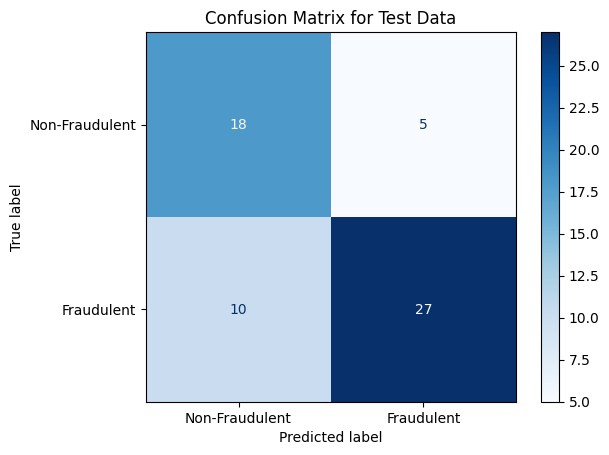

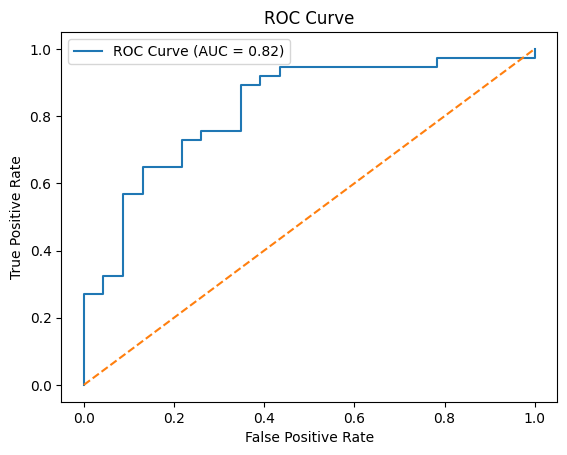

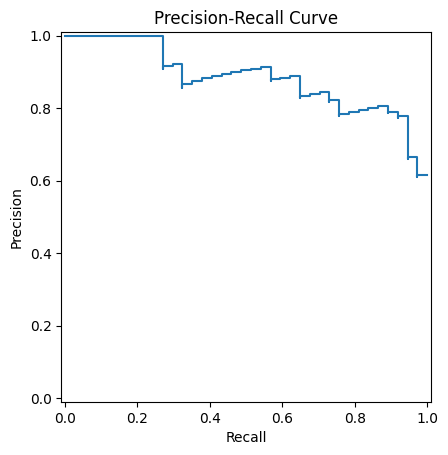

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack  # For combining sparse matrices
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV dataset
file_path = '/content/modified_final_dataset.csv'
dataset = pd.read_csv(file_path)

# Extract features and labels
X_fillings = dataset['Fillings']
X_llm_response = dataset['LLM_Response']
y = dataset['Fraud']

# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    pd.concat([X_fillings, X_llm_response], axis=1),
    y,
    test_size=0.3,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize TF-IDF vectorizers for both features
tfidf_vectorizer_fillings = TfidfVectorizer()
tfidf_vectorizer_llm = TfidfVectorizer()

# Transform "Fillings" feature
X_train_fillings_tfidf = tfidf_vectorizer_fillings.fit_transform(X_train['Fillings'])
X_val_fillings_tfidf = tfidf_vectorizer_fillings.transform(X_val['Fillings'])
X_test_fillings_tfidf = tfidf_vectorizer_fillings.transform(X_test['Fillings'])

# Transform "LLM_Response" feature
X_train_llm_tfidf = tfidf_vectorizer_llm.fit_transform(X_train['LLM_Response'])
X_val_llm_tfidf = tfidf_vectorizer_llm.transform(X_val['LLM_Response'])
X_test_llm_tfidf = tfidf_vectorizer_llm.transform(X_test['LLM_Response'])

# Combine both features into a single sparse matrix
X_train_combined = hstack([X_train_fillings_tfidf, X_train_llm_tfidf])
X_val_combined = hstack([X_val_fillings_tfidf, X_val_llm_tfidf])
X_test_combined = hstack([X_test_fillings_tfidf, X_test_llm_tfidf])

# Create and train the SVM model
svm_model = SVC(kernel='linear', probability=True)  # Set probability=True for decision function
svm_model.fit(X_train_combined, y_train)

# Validate the model
y_val_pred = svm_model.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, pos_label='yes')
val_recall = recall_score(y_val, y_val_pred, pos_label='yes')
val_f1 = f1_score(y_val, y_val_pred, pos_label='yes')

# Test the model
y_test_pred = svm_model.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label='yes')
test_recall = recall_score(y_test, y_test_pred, pos_label='yes')
test_f1 = f1_score(y_test, y_test_pred, pos_label='yes')

print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)

# Calculate decision function for ROC and Precision-Recall curves
y_test_prob = svm_model.decision_function(X_test_combined)
fpr, tpr, _ = roc_curve(y_test, y_test_prob, pos_label='yes')
roc_auc = roc_auc_score(y_test, y_test_prob)

# Compute the precision and recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob, pos_label='yes')

# Plot Confusion Matrix for Test Data
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraudulent', 'Fraudulent'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.show()

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot the precision-recall curve
disp_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
disp_pr.plot()
plt.title('Precision-Recall Curve')
plt.show()


<ipython-input-24-3fb1cd8aae7e>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = dataset['Fraud'].replace({'yes': 1, 'no': 0})


Validation Accuracy: 0.85
Validation Precision: 0.9090909090909091
Validation Recall: 0.7407407407407407
Validation F1-score: 0.8163265306122449
Test Accuracy: 0.825
Test Precision: 0.9047619047619048
Test Recall: 0.7916666666666666
Test F1-score: 0.8444444444444444


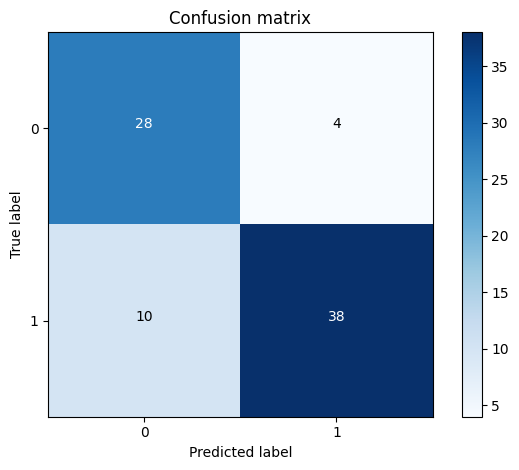

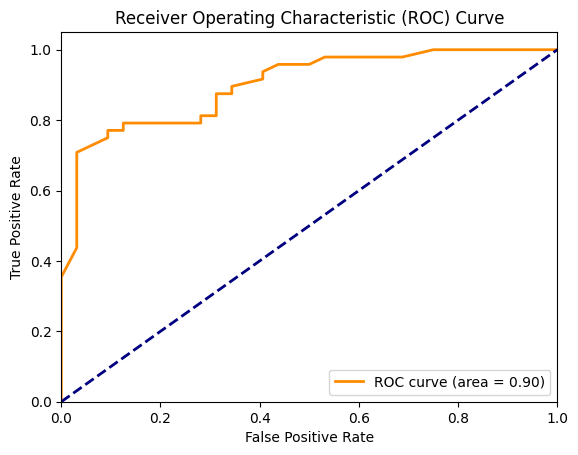

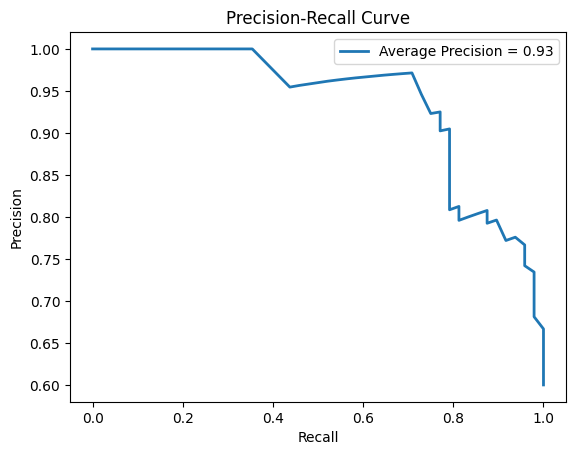

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack  # For combining sparse matrices
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import itertools

# Load Dataset
file_path = "/content/modified_final_dataset.csv"
dataset = pd.read_csv(file_path)

# Extract features and labels
X_fillings = dataset['Fillings']
X_llm_response = dataset['LLM_Response']
y = dataset['Fraud'].replace({'yes': 1, 'no': 0})

# Split Data into Train, Validation, and Test Sets
X_temp, X_test, y_temp, y_test = train_test_split(
    pd.concat([X_fillings, X_llm_response], axis=1),
    y,
    test_size=0.4,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize TF-IDF Vectorizers for Fillings and LLM_Response
tfidf_vectorizer_fillings = TfidfVectorizer(max_features=5000)
tfidf_vectorizer_llm = TfidfVectorizer(max_features=5000)

# Transform Fillings
X_train_fillings_tfidf = tfidf_vectorizer_fillings.fit_transform(X_train['Fillings'])
X_val_fillings_tfidf = tfidf_vectorizer_fillings.transform(X_val['Fillings'])
X_test_fillings_tfidf = tfidf_vectorizer_fillings.transform(X_test['Fillings'])

# Transform LLM_Response
X_train_llm_tfidf = tfidf_vectorizer_llm.fit_transform(X_train['LLM_Response'])
X_val_llm_tfidf = tfidf_vectorizer_llm.transform(X_val['LLM_Response'])
X_test_llm_tfidf = tfidf_vectorizer_llm.transform(X_test['LLM_Response'])

# Combine both features
X_train_combined = hstack([X_train_fillings_tfidf, X_train_llm_tfidf])
X_val_combined = hstack([X_val_fillings_tfidf, X_val_llm_tfidf])
X_test_combined = hstack([X_test_fillings_tfidf, X_test_llm_tfidf])

# Create and Train Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_combined, y_train)

# Evaluate on Validation Data
y_val_pred = random_forest_model.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1_score = f1_score(y_val, y_val_pred)

# Evaluate on Test Data
y_test_pred = random_forest_model.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)

# Print Results
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1_score)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1_score)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    average_precision = average_precision_score(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, lw=2, label='Average Precision = %0.2f' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")

# Predict probabilities for Validation and Test Set
y_val_prob = random_forest_model.predict_proba(X_val_combined)[:, 1]
y_test_prob = random_forest_model.predict_proba(X_test_combined)[:, 1]

# Plot Confusion Matrix for Test Set
plot_confusion_matrix(y_test, y_test_pred, classes=[0, 1])
plt.show()

# Plot ROC Curve for Test Set
plot_roc_curve(y_test, y_test_prob)
plt.show()

# Plot Precision-Recall Curve for Test Set
plot_precision_recall_curve(y_test, y_test_prob)
plt.show()


In [ ]:
import xgboost as xgb
import sklearn

print("XGBoost version:", xgb.__version__)
print("XGBoost path:", xgb.__file__)
print("Scikit-learn version:", sklearn.__version__)



XGBoost version: 2.1.3
XGBoost path: /usr/local/lib/python3.10/dist-packages/xgboost/__init__.py
Scikit-learn version: 1.5.2


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from scipy.sparse import hstack  # For combining sparse matrices

# Load the dataset
data = pd.read_csv('/content/modified_final_dataset.csv')

# Split data into train, validation, and test sets with stratification
train, temp = train_test_split(data, test_size=0.4, random_state=62, stratify=data['Fraud'])
val, test = train_test_split(temp, test_size=0.5, random_state=62, stratify=temp['Fraud'])

# Initialize TF-IDF vectorizers for both Fillings and LLM_Response
tfidf_fillings = TfidfVectorizer(max_features=5000)
tfidf_llm = TfidfVectorizer(max_features=5000)

# Vectorize Fillings
X_train_fillings = tfidf_fillings.fit_transform(train['Fillings'])
X_val_fillings = tfidf_fillings.transform(val['Fillings'])
X_test_fillings = tfidf_fillings.transform(test['Fillings'])

# Vectorize LLM_Response
X_train_llm = tfidf_llm.fit_transform(train['LLM_Response'])
X_val_llm = tfidf_llm.transform(val['LLM_Response'])
X_test_llm = tfidf_llm.transform(test['LLM_Response'])

# Combine both features
X_train_combined = hstack([X_train_fillings, X_train_llm])
X_val_combined = hstack([X_val_fillings, X_val_llm])
X_test_combined = hstack([X_test_fillings, X_test_llm])

# Convert labels to numerical format
y_train = train['Fraud'].map({'no': 0, 'yes': 1}).values
y_val = val['Fraud'].map({'no': 0, 'yes': 1}).values
y_test = test['Fraud'].map({'no': 0, 'yes': 1}).values

# Create DMatrix
dtrain = xgb.DMatrix(X_train_combined, label=y_train)
dval = xgb.DMatrix(X_val_combined, label=y_val)
dtest = xgb.DMatrix(X_test_combined, label=y_test)

# Define parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.3,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'eval_metric': 'logloss'
}

# Define evaluation set
evals = [(dtrain, 'train'), (dval, 'validation')]

# Train the model with early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

# Make predictions on validation and test sets
y_val_pred_prob = bst.predict(dval)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

y_test_pred_prob = bst.predict(dtest)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Evaluation
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Precision:", precision_score(y_val, y_val_pred))
print("Validation Recall:", recall_score(y_val, y_val_pred))
print("Validation F1-score:", f1_score(y_val, y_val_pred))

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1-score:", f1_score(y_test, y_test_pred))


[0]	train-logloss:0.46386	validation-logloss:0.48360
[1]	train-logloss:0.33095	validation-logloss:0.36644
[2]	train-logloss:0.24463	validation-logloss:0.30360
[3]	train-logloss:0.18589	validation-logloss:0.26295
[4]	train-logloss:0.14422	validation-logloss:0.23012
[5]	train-logloss:0.11454	validation-logloss:0.21763
[6]	train-logloss:0.09268	validation-logloss:0.19202
[7]	train-logloss:0.07619	validation-logloss:0.18207
[8]	train-logloss:0.06365	validation-logloss:0.16536
[9]	train-logloss:0.05409	validation-logloss:0.15601
[10]	train-logloss:0.04851	validation-logloss:0.15137
[11]	train-logloss:0.04197	validation-logloss:0.14183
[12]	train-logloss:0.03883	validation-logloss:0.13463
[13]	train-logloss:0.03418	validation-logloss:0.13970
[14]	train-logloss:0.03039	validation-logloss:0.13393
[15]	train-logloss:0.02898	validation-logloss:0.13500
[16]	train-logloss:0.02781	validation-logloss:0.13510
[17]	train-logloss:0.02677	validation-logloss:0.13473
[18]	train-logloss:0.02589	validation-

### **Prediction**

In [ ]:
# Pass the downloaded json type financial report to the python file in github repo Fraud_PE/Fraud_PE.py
# then will get a Output Csv file with financial report content and LLM Response


# Import necessary libraries
import pandas as pd

# Upload the CSV file
print("Please upload your CSV file.")
uploaded = files.upload()

# Assuming the uploaded file is the first key in the dictionary
file_name = list(uploaded.keys())[0]

# Load the CSV into a DataFrame
df = pd.read_csv(file_name)

# Check if the CSV has at least 6 columns
if df.shape[1] < 6:
    raise ValueError("The input CSV must have at least 6 columns.")

# Combine the first five columns into one column named 'Fillings'
df['Fillings'] = df.iloc[:, 0:5].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Rename the sixth column to 'LLM_Response'
df = df.rename(columns={df.columns[5]: 'LLM_Response'})

# Drop the original first five columns
df = df[['Fillings', 'LLM_Response']]

# Display the first few rows of the updated DataFrame
print("Updated DataFrame:")
print(df.head())

# Save the updated DataFrame to a new CSV file
output_file_name = "updated_file.csv"
df.to_csv(output_file_name, index=False)



In [ ]:
import pandas as pd
from scipy.sparse import hstack  # For combining sparse matrices
import numpy as np

def clean_text(text):
    """
    Cleans the input text by removing special characters, punctuation,
    newline characters, and converting to lowercase.
    """
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def predict_with_majority_voting(csv_path):
    """
    Processes a CSV file with columns 'Fillings' and 'LLM_Response', evaluates with
    all four models (Logistic Regression, SVM, Random Forest, XGBoost), and calculates
    majority voting and confidence scores.

    Args:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with predictions and confidence scores.
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Clean the input text
    df['Fillings'] = df['Fillings'].apply(clean_text)
    df['LLM_Response'] = df['LLM_Response'].apply(clean_text)

    # Initialize an empty list to store predictions
    results = []

    # Iterate through the rows of the DataFrame
    for _, row in df.iterrows():
        # Transform inputs using the trained TF-IDF vectorizers
        filling_tfidf = tfidf_fillings.transform([row['Fillings']])
        llm_response_tfidf = tfidf_llm.transform([row['LLM_Response']])
        combined_features = hstack([filling_tfidf, llm_response_tfidf])

        # Get predictions from all models
        logistic_pred = logistic_model.predict(combined_features)[0]
        svm_pred = svm_model.predict(combined_features)[0]
        random_forest_pred = random_forest_model.predict(combined_features)[0]
        xgboost_pred = xgb_model.predict(xgb.DMatrix(combined_features))[0]

        # Convert XGBoost prediction to binary (0 or 1)
        xgboost_pred = 1 if xgboost_pred > 0.5 else 0

        # Store individual model predictions
        model_predictions = [logistic_pred, svm_pred, random_forest_pred, xgboost_pred]

        # Calculate majority vote
        majority_vote = np.mean(model_predictions) >= 0.5
        final_prediction = 1 if majority_vote else 0

        # Calculate confidence score (percentage of models voting for the final prediction)
        confidence_score = np.mean(model_predictions) * 100

        # Append results
        results.append({
            'Fillings': row['Fillings'],
            'LLM_Response': row['LLM_Response'],
            'Logistic_Prediction': logistic_pred,
            'SVM_Prediction': svm_pred,
            'Random_Forest_Prediction': random_forest_pred,
            'XGBoost_Prediction': xgboost_pred,
            'Final_Prediction': final_prediction,
            'Confidence_Score': confidence_score
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
csv_path = r"D:\HKU\APAI4011\chatbot\Data\input_file.csv"
predictions_df = predict_with_majority_voting(csv_path)

# Print the results
print(predictions_df)
print(df['LLM_Response'])
# Optionally, save to a new CSV
output_path = r"D:\HKU\APAI4011\chatbot\Data\predictions_with_confidence.csv"
predictions_df.to_csv(output_path, index=False)


Predicted Label: Non-Fraudulent
Confidence Score: 1.00

Based on the summarized content, here's an analysis of the likelihood of fraud for Stanley Black & Decker Inc., and evidence for or against the possibility of fraud:

1. **Ranking the Likelihood of Fraud (1-10):**

   - **Likely Fraud Score: 3/10**  
     This score suggests a low probability of fraud based on the summarized content provided. 
     The presence of standard audits, internal controls, and non-biased language indicates compliance with typical financial transparency practices. 
     However, certain areas in the detailed report (such as significant non-GAAP adjustments and asset impairment charges) warrant further scrutiny.

2. **Evidence for or Against Fraud Statement:**

   - **Evidence Against Fraud:**
     - The company has conducted an audit, facilitated by an "independent registered public accounting firm," 
       and maintained a "management" report on internal control over financial reporting." This indicates